### 가상환경 설정 및 gpu설치

- [작업1] gpu확인
    - 윈도우키 + R : dxdiag ==> 실행후 [디스플레이] 에서 NDVIDIA 설치여부 확인

<br />

- [작업2] 콘다 설치되었을때의 가상환경 설정(파이썬만 설정되어 있는 경우는 다름)
    - 아나콘다 프롬프트 실행 => (base) 콘다프롬프트실행됨
    - conda create -n 가상환경이름 python=파이썬버젼 (python=파이썬버젼 생략하면 설치된 버전으로 사용됨)
        - conda create -n gpu2.6 python=3.7
    - activate gpu2.6 => 가상환경 실행
        - (gup2.6) 콘다프롬프트 나옴
    - deactivate => 가상환경 종료
    - conda info --envs => 설치된 가상환경 리스트 확인
    - 가상환경 제거시 => conda env remove -n 가상환경 이름

<br />

- [작업3] 가상환경에 gpu텐서설치하기
    - 가상환경 실행:
        - activate gpu2.6
    - gpu텐서 설치: (원칙은 시스템 환경에 맞는 CUDA toolkit 다운 => cuda 버전에 맞는 cudnn 다운로드 =>시스템환경변수편집)
        - conda install -c anaconda tensorflow-gpu==2.6
        - conda install keras==2.6
    - GPU텐서 동작여부 확인 (python 실행) => GPU 리스트 출력되어야함
        - pyhton
        - from tensorflow.python.client import device_lib
        - device_lib.list_local_devices()
        - exit()
    - 작업에필요한모듈설치:
        - conda install jupyter pandas numpy seaborn matplotlib
    - 주피터실행후 작업

In [3]:
import os
import logging
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
import PIL.Image

import tensorflow as tf
import tensorflow_datasets as tfds

In [12]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [5]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/HP/.keras/datasets/flower_photos')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


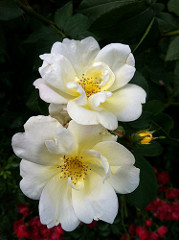

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

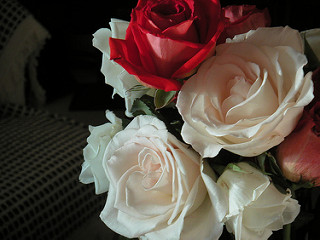

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [11]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


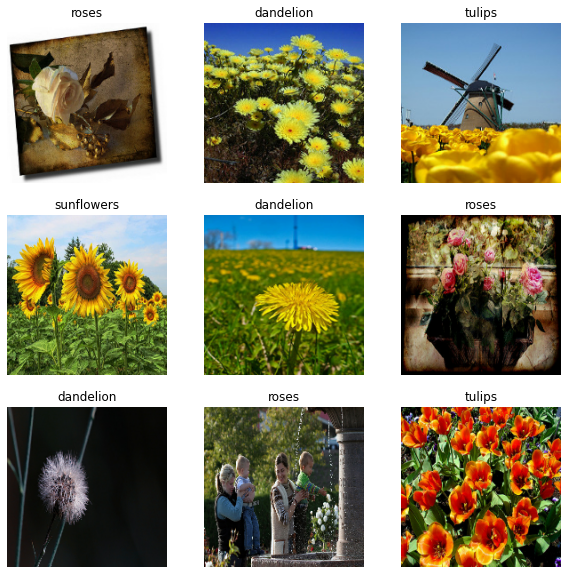

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### 전이학습을 이용하여 모델링 완성 (어떤 전이학습을 사용해도 됨)

- 모델구성
- 시각화
- model.evaluate 로 정확도 평가
- new_image를 넣어서 꽃 label링 잘 되었는지 평가

#### 테스트이미지를 평가지표 완성

- 혼동행렬 제작

### VGG

In [14]:
img_shape = (img_height, img_width, 3)

# include_top = False인 경우 input_shape = img_size 지정 필요
VGG16_MODEL = tf.keras.applications.VGG16(input_shape=img_shape,
                                          include_top=False,
                                          weights='imagenet')

58889256/58889256 [==============================] - 1s 0us/step


In [15]:
VGG16_MODEL.trainable = False  # VGG16모델 가중치는 변하지 않음.

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(len(class_names),
                                         activation='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
model = tf.keras.Sequential(
    [VGG16_MODEL, global_average_layer, prediction_layer])

In [ ]:
## 참고:cpu를 사용하면
with tf.device('/cpu:0'):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs = 2
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_steps=2,
                        validation_data=(val_ds))

In [18]:
# 참고: gpu사용
with tf.device('/device:GPU:0'):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    epochs = 7
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_steps=2,
                        validation_data=(val_ds))

Epoch 1/7
92/92 [==============================] - 10s 97ms/step - loss: 1.3331 - accuracy: 0.7354 - val_loss: 1.1813 - val_accuracy: 0.7656
Epoch 2/7
92/92 [==============================] - 9s 96ms/step - loss: 0.9011 - accuracy: 0.8035 - val_loss: 1.5896 - val_accuracy: 0.7344
Epoch 3/7
92/92 [==============================] - 9s 95ms/step - loss: 0.6704 - accuracy: 0.8317 - val_loss: 1.8944 - val_accuracy: 0.7344
Epoch 4/7
92/92 [==============================] - 8s 90ms/step - loss: 0.5271 - accuracy: 0.8525 - val_loss: 1.3601 - val_accuracy: 0.7656
Epoch 5/7
92/92 [==============================] - 8s 90ms/step - loss: 0.4331 - accuracy: 0.8740 - val_loss: 1.0135 - val_accuracy: 0.8125
Epoch 6/7
92/92 [==============================] - 8s 91ms/step - loss: 0.3694 - accuracy: 0.8818 - val_loss: 0.9611 - val_accuracy: 0.7656
Epoch 7/7
92/92 [==============================] - 9s 92ms/step - loss: 0.3149 - accuracy: 0.8971 - val_loss: 0.8983 - val_accuracy: 0.7969


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath = "./data/model/Ch14-4-bestmodel.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath,
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#모델을 실행합니다
epochs = 15
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_steps=2,
                    validation_data=(val_ds),
                    verbose=1,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/15
92/92 [==============================] - 10s 100ms/step - loss: 0.3222 - accuracy: 0.8954 - val_loss: 1.4369 - val_accuracy: 0.7344
Epoch 2/15
92/92 [==============================] - 9s 93ms/step - loss: 0.2579 - accuracy: 0.9131 - val_loss: 0.3210 - val_accuracy: 0.9375
Epoch 3/15
92/92 [==============================] - 9s 92ms/step - loss: 0.2401 - accuracy: 0.9196 - val_loss: 0.8123 - val_accuracy: 0.7969
Epoch 4/15
92/92 [==============================] - 8s 90ms/step - loss: 0.2124 - accuracy: 0.9227 - val_loss: 1.5915 - val_accuracy: 0.8281
Epoch 5/15
92/92 [==============================] - 8s 89ms/step - loss: 0.1787 - accuracy: 0.9329 - val_loss: 0.9803 - val_accuracy: 0.7344
Epoch 6/15
92/92 [==============================] - 8s 89ms/step - loss: 0.1609 - accuracy: 0.9431 - val_loss: 0.5270 - val_accuracy: 0.7656
Epoch 7/15
92/92 [==============================] - 8s 90ms/step - loss: 0.1464 - accuracy: 0.9499 - val_loss: 0.8236 - val_accuracy: 0.8438
Epoch 8/15


<Figure size 864x288 with 0 Axes>

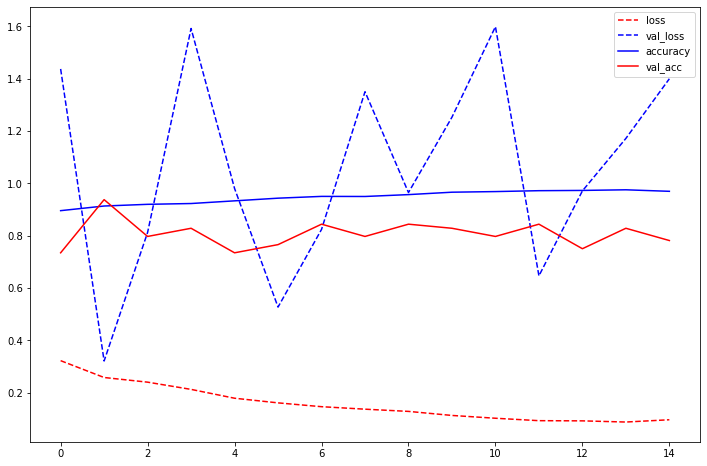

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], '--', c='red')
plt.plot(history.history['val_loss'], '--', c='blue')
plt.plot(history.history['accuracy'], c='blue')
plt.plot(history.history['val_accuracy'], c='red')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_acc'])
plt.show()

In [21]:
model.evaluate(val_ds)
# 손실값, 정확도

23/23 [==============================] - 6s 246ms/step - loss: 0.9671 - accuracy: 0.8283


[0.9670742750167847, 0.8283378481864929]

(180, 180, 3)
(1, 180, 180, 3)
1/1 [==============================] - 1s 962ms/step
This image most likely belongs to sunflowers with a 40.46 percent confidence.


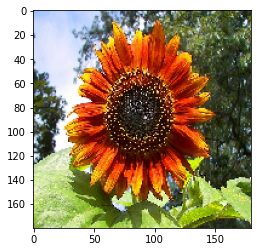

In [24]:
## 평가하기
import keras

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(sunflower_path,
                                            target_size=(img_height,
                                                         img_width))

plt.imshow(img)

img_array = tf.keras.preprocessing.image.img_to_array(img)
print(np.shape(img_array))

img_array = tf.expand_dims(img_array, 0)  # Create a batch
print(np.shape(img_array))

predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])
score
print("This image most likely belongs to {} with a {:.2f} percent confidence.".
      format(class_names[np.argmax(score)], 100 * np.max(score)))

#### 평가지표

In [25]:
test_all_label = []
test_all_image = []
for test_img, test_label in val_ds:
    test_all_label.extend(test_label.numpy())
    test_all_image.extend(test_img.numpy())
np.shape(test_all_label), np.shape(test_all_image)

((734,), (734, 180, 180, 3))

In [26]:
model.predict(test_all_image[0].reshape(1, 180, 180, 3), test_all_label[0])

1/1 [==============================] - 0s 15ms/step


array([[4.8243304e-10, 1.0000000e+00, 5.5790077e-12, 9.0206162e-11,
        2.2471933e-13]], dtype=float32)

In [35]:
from tqdm import tqdm

result = []
for img in tqdm(test_all_image):
    softmax = model.predict(img.reshape(1, 180, 180, 3), verbose=0)
    result.append(np.argmax(softmax))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 734/734 [00:40<00:00, 18.32it/s]


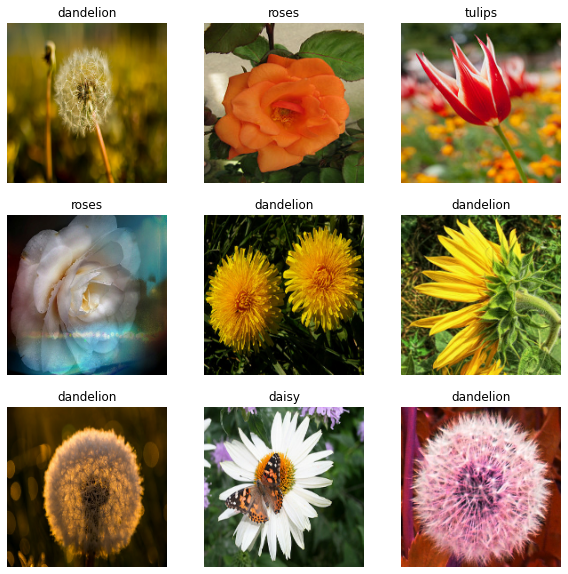

In [36]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_all_image[i].astype("uint8"))
    plt.title(class_names[result[i]])
    plt.axis("off")

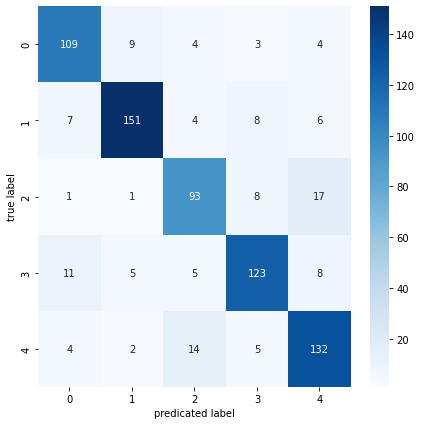

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#혼돈행렬만들기
plt.figure(figsize=(7, 7))
cm = confusion_matrix(test_all_label, result)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')
plt.show()